# Mercado Livre API - Overview da API a partir de uma query
Esse notebook apresenta diferentes métricas que se pode obter ao realizar uma query à API do Mercado Libre. 

(No momento, experimentando com diferentes visualizações. Ao finalizar uma versão, a descrição dos passos será completada de acordo).

## Imports e configurações gerais

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import requests
import pandas as pd

from pandas import Series, DataFrame

from IPython.core.display import Image, display

# Charts styling
#plt.style.use('fivethirtyeight')
#plt.style.use('bmh')
plt.style.use('ggplot')
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8 # increases figure size
matplotlib.rcParams.update({'font.size': 14}) # increases chart font size
rcParams['font.family'] = 'Arial Narrow'

In [2]:
# style to enhance df viz, from https://github.com/brandon-rhodes/pycon-pandas-tutorial
from IPython.core.display import HTML
css = open('style-table.css').read() #+ open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

## Parâmetros de entrada

In [3]:
# Sets input parameters 
DAYS_AGO = 365 # days to look back in visits history
ITEMS_TO_QUERY = 200 # max. number of results returned from query (max. permitted by ML is 200)
ITEMS_TO_PLOT = 10 # list of "ITEMS_TO_PLOT" top sold items; e.g. if 10, visits from top 10 sold itens will be plotted

## Busca de itens a partir de uma query definida pelo usuário

- Get dos resultados da busca
- Ordenamento dos itens por mais vendidos e remoção de itens duplicados
- Corte de itens pelo limite *ITEMS_TO_PLOT*

In [4]:
### REQUEST: gets items according to search for 'query' 

#query = "kit painel solar"
query = input('Qual a query desejada? ')

url = 'https://api.mercadolibre.com/sites/MLB/search?q=' + query +'&limit=' + str(ITEMS_TO_QUERY)
print('Buscando por "' + query + '"...')
data = requests.get(url).json()

results = data["results"] # saves content from json in variable
df = DataFrame(results) # converts to a pandas df
print(str(len(df)) + ' itens encontrados.')

Qual a query desejada? kit painel solar
Buscando por "kit painel solar"...
136 itens encontrados.


In [5]:
#df.seller[0]

In [6]:
df = df[["id", "title", "price", "sold_quantity", "available_quantity", "permalink", "thumbnail", "seller_address"]] # gets only interesting columns

# sorts items by sold quantity and deletes duplicates with less sales (assuming they'd be 0)
df = df.sort_values(by="sold_quantity", ascending=False)
df = df.drop_duplicates(subset=['title'], keep='first')

ids = df.id.values[0:ITEMS_TO_PLOT] # gets top sold items ML ids in a list

df = df.set_index('id') # sets index to id

# adds revenue column by an operation with sold_quantity and price
df['revenue'] = df['sold_quantity'] * df['price']
total_revenue = df['revenue'].sum()


#df
df.head()

,title,price,sold_quantity,available_quantity,permalink,thumbnail,seller_address,revenue
id,,,,,,,,
MLB712968328,Kit Painel Solar Fotovoltaico E Controlador De...,354.9,97,6,http://produto.mercadolivre.com.br/MLB-7129683...,http://mlb-s1-p.mlstatic.com/13411-MLB20076556...,"{'latitude': -23.5721828, 'zip_code': '', 'sta...",34425.3
MLB684532632,Kit Demonstrativo Célula Painel Placa Energia ...,29.9,71,948,http://produto.mercadolivre.com.br/MLB-6845326...,http://mlb-s2-p.mlstatic.com/113605-MLB2505261...,"{'latitude': -23.6067376, 'zip_code': '', 'sta...",2122.9
MLB695065272,Kit Painel Solar Placa Célula Fotovoltaica 150...,1459.0,56,962,http://produto.mercadolivre.com.br/MLB-6950652...,http://mlb-s1-p.mlstatic.com/182101-MLB2027923...,"{'latitude': -19.4623474, 'zip_code': '', 'sta...",81704.0
MLB696113241,Kit Bomba Dágua Shurflo Com Painél Solar De 14...,1595.0,30,9,http://produto.mercadolivre.com.br/MLB-6961132...,http://mlb-s1-p.mlstatic.com/591901-MLB2044380...,"{'latitude': -23.5493233, 'zip_code': '', 'sta...",47850.0
MLB754575430,Kit Painel Solar+ Bateria+ Controlador+ Invers...,798.0,25,5,http://produto.mercadolivre.com.br/MLB-7545754...,http://mlb-s1-p.mlstatic.com/804905-MLB2510574...,"{'latitude': -23.5205435, 'zip_code': '', 'sta...",19950.0


## Resultado da busca

Os 10 itens mais vendidos: 



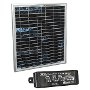

MLB712968328 - Kit Painel Solar Fotovoltaico E Controlador De Carga
http://produto.mercadolivre.com.br/MLB-712968328-kit-painel-solar-fotovoltaico-e-controlador-de-carga-_JM


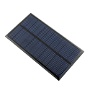

MLB684532632 - Kit Demonstrativo Célula Painel Placa Energia Solar 6v 150ma
http://produto.mercadolivre.com.br/MLB-684532632-kit-demonstrativo-celula-painel-placa-energia-solar-6v-150ma-_JM


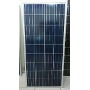

MLB695065272 - Kit Painel Solar Placa Célula Fotovoltaica 150w + Acessórios
http://produto.mercadolivre.com.br/MLB-695065272-kit-painel-solar-placa-celula-fotovoltaica-150w-acessorios-_JM


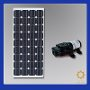

MLB696113241 - Kit Bomba Dágua Shurflo Com Painél Solar De 140w ( Placa )
http://produto.mercadolivre.com.br/MLB-696113241-kit-bomba-dagua-shurflo-com-painel-solar-de-140w-placa--_JM


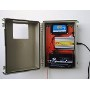

MLB754575430 - Kit Painel Solar+ Bateria+ Controlador+ Inversor 12v P/110v
http://produto.mercadolivre.com.br/MLB-754575430-kit-painel-solar-bateria-controlador-inversor-12v-p110v-_JM


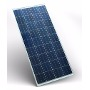

MLB727650542 - Kit Painel Placa Energia Solar 150w + Controlador 20a + Cabo
http://produto.mercadolivre.com.br/MLB-727650542-kit-painel-placa-energia-solar-150w-controlador-20a-cabo-_JM


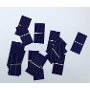

MLB779069064 - Kit Célula Solar Para Montar Painel 10w 12v.
http://produto.mercadolivre.com.br/MLB-779069064-kit-celula-solar-para-montar-painel-10w-12v-_JM


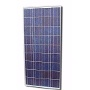

MLB765601179 - Kit Placa Painel Solar 200w + Controlador De Carga Solar 20a
http://produto.mercadolivre.com.br/MLB-765601179-kit-placa-painel-solar-200w-controlador-de-carga-solar-20a-_JM


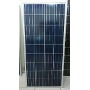

MLB773028235 - Kit Painel Placa Solar 150w + Bateria + Inversor + Cabos
http://produto.mercadolivre.com.br/MLB-773028235-kit-painel-placa-solar-150w-bateria-inversor-cabos-_JM


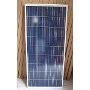

MLB760460786 - Kit Painel Placa Solar Fotovoltaica 150w + Cabos + Mc4
http://produto.mercadolivre.com.br/MLB-760460786-kit-painel-placa-solar-fotovoltaica-150w-cabos-mc4-_JM


In [7]:
# prints URLs from itens in chart

print('Os ' + str(ITEMS_TO_PLOT) + ' itens mais vendidos:', '\n')
for index, row in df.head(ITEMS_TO_PLOT).iterrows():
    display(Image(df.loc[index, 'thumbnail']))
    print(index + ' - ' + df.loc[index, 'title']) # uses loc taking advantage of indexing by id made previously
    print(df.loc[index, 'permalink'])
    

## Itens mais vendidos e seus preços

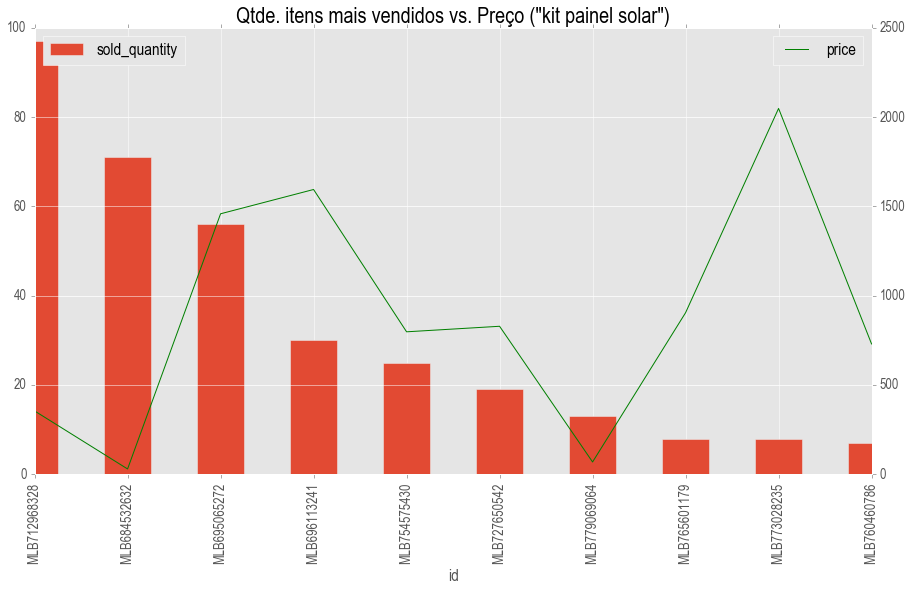

In [8]:
# sold quantity vs. unit price

# procedure to handle secondary Y axis
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()

y0 = df.head(ITEMS_TO_PLOT).sold_quantity.plot(kind='bar', ax=ax0)#, label='Itens vendidos')
y1 = df.head(ITEMS_TO_PLOT).price.plot(secondary_y=True, style='g', ax=ax1)#, label='Preço unitário')
y0.legend(loc=2) # bar legend to the left
y1.legend(loc=0) # line legend to the right

plt.title('Qtde. itens mais vendidos vs. Preço ("' + query + '")', fontsize=22)
plt.show()
plt.close()

## Faturamento por item

O faturamento total ("kit painel solar") = R$ 300327.08


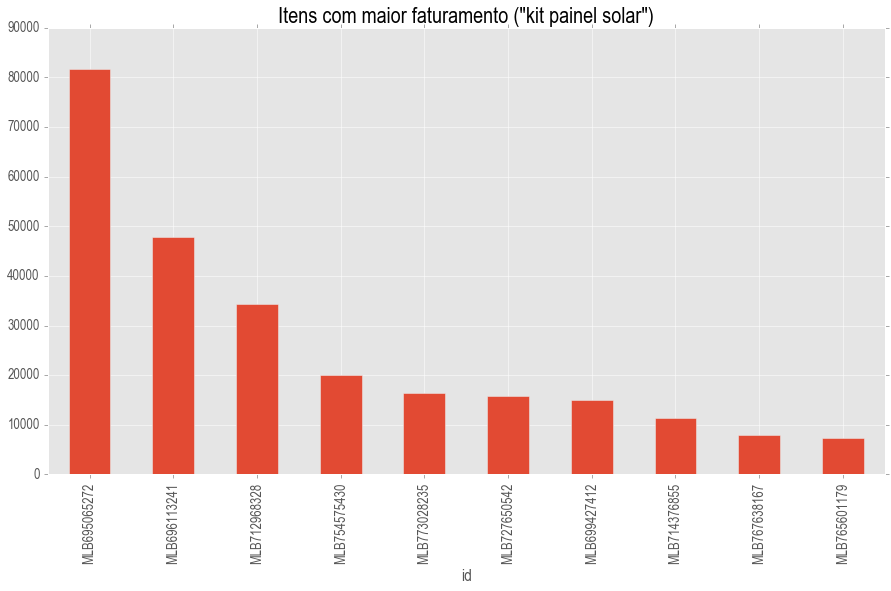

In [9]:
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))
df['revenue'].sort_values(ascending=False).head(ITEMS_TO_PLOT).plot(kind='bar')
plt.title('Itens com maior faturamento ("' + query + '")', fontsize=22)

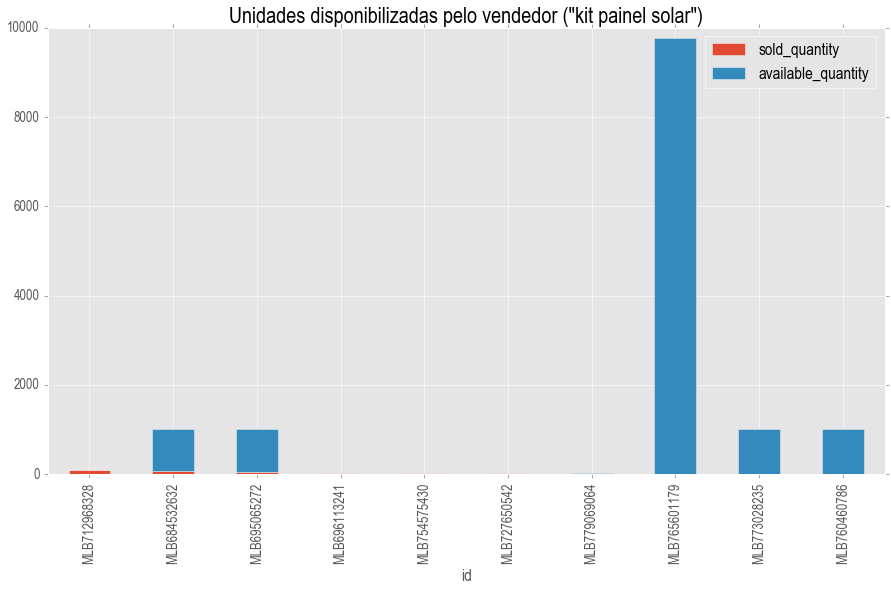

In [10]:
# total amount of each item (sold + stock)

df[['sold_quantity', 'available_quantity']].head(ITEMS_TO_PLOT).plot(kind='bar', stacked=True)
plt.title('Unidades disponibilizadas pelo vendedor ("' + query + '")', fontsize=22)

## Dados por cidade e estado (qtde. de anúncios e faturamento)

In [11]:
# location and stuff...

df2 = df # creates copy to play with

cities = [] # empty list to hold city names
states = [] # empty list to hold state names
for index, row in df2.iterrows():
    cities.append(row['seller_address']['city']['name'])    
    states.append(row['seller_address']['state']['name'])    

df2['city'] = cities
df2['state'] = states
df2.head()

,title,price,sold_quantity,available_quantity,permalink,thumbnail,seller_address,revenue,city,state
id,,,,,,,,,,
MLB712968328,Kit Painel Solar Fotovoltaico E Controlador De...,354.9,97,6,http://produto.mercadolivre.com.br/MLB-7129683...,http://mlb-s1-p.mlstatic.com/13411-MLB20076556...,"{'latitude': -23.5721828, 'zip_code': '', 'sta...",34425.3,São Paulo,São Paulo
MLB684532632,Kit Demonstrativo Célula Painel Placa Energia ...,29.9,71,948,http://produto.mercadolivre.com.br/MLB-6845326...,http://mlb-s2-p.mlstatic.com/113605-MLB2505261...,"{'latitude': -23.6067376, 'zip_code': '', 'sta...",2122.9,Rio Claro,São Paulo
MLB695065272,Kit Painel Solar Placa Célula Fotovoltaica 150...,1459.0,56,962,http://produto.mercadolivre.com.br/MLB-6950652...,http://mlb-s1-p.mlstatic.com/182101-MLB2027923...,"{'latitude': -19.4623474, 'zip_code': '', 'sta...",81704.0,Ipatinga,Minas Gerais
MLB696113241,Kit Bomba Dágua Shurflo Com Painél Solar De 14...,1595.0,30,9,http://produto.mercadolivre.com.br/MLB-6961132...,http://mlb-s1-p.mlstatic.com/591901-MLB2044380...,"{'latitude': -23.5493233, 'zip_code': '', 'sta...",47850.0,São Paulo,São Paulo
MLB754575430,Kit Painel Solar+ Bateria+ Controlador+ Invers...,798.0,25,5,http://produto.mercadolivre.com.br/MLB-7545754...,http://mlb-s1-p.mlstatic.com/804905-MLB2510574...,"{'latitude': -23.5205435, 'zip_code': '', 'sta...",19950.0,São Paulo,São Paulo


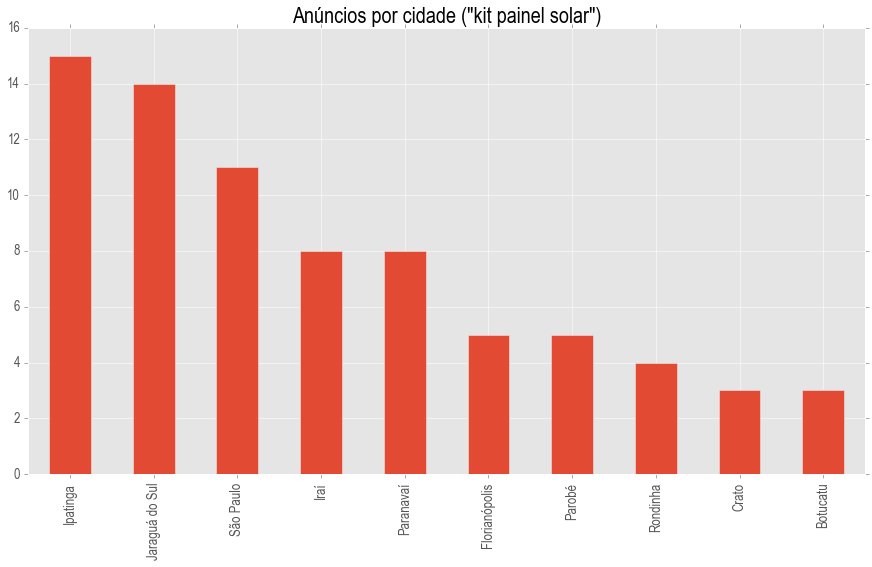

In [12]:
# plots itens by cities

df2.city.value_counts().head(10).plot(kind='bar')
plt.title('Anúncios por cidade ("' + query + '")', fontsize=22)

O faturamento total ("kit painel solar") = R$ 300327.08


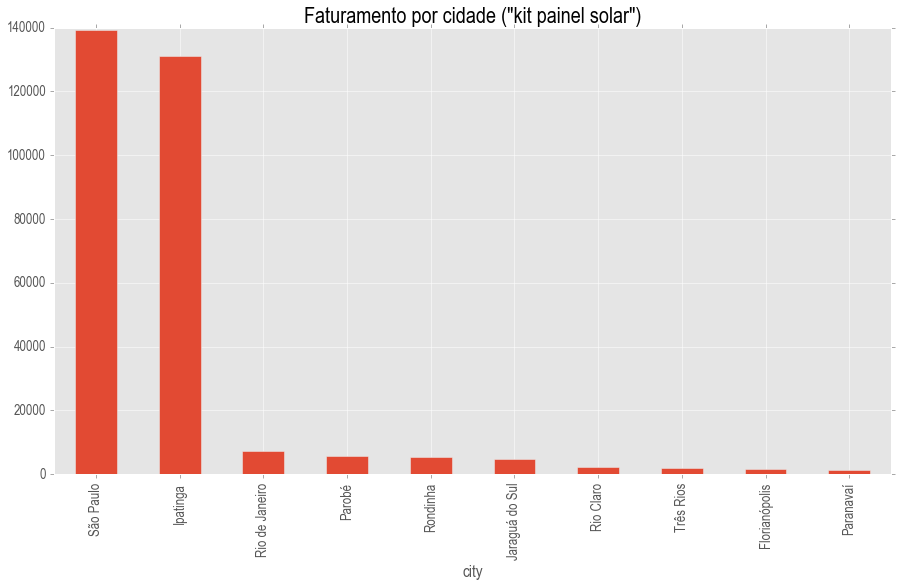

In [13]:
# revenue per city
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))

revenue_by_city = df2.groupby('city').sum().revenue # aggregates data by city, sums by revenue
revenue_by_city.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Faturamento por cidade ("' + query + '")', fontsize=22)

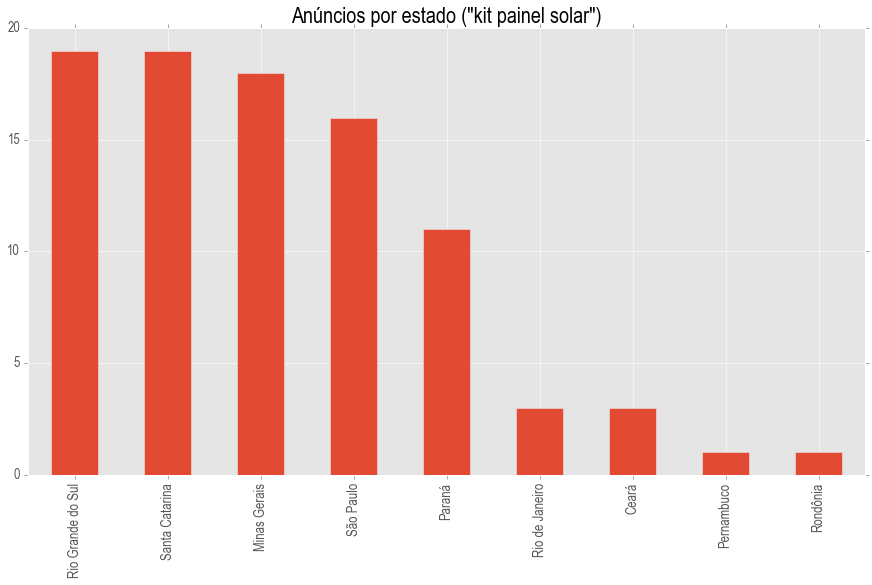

In [14]:
# plots itens by states
df2.state.value_counts().plot(kind='bar')
plt.title('Anúncios por estado ("' + query + '")', fontsize=22)

O faturamento total ("kit painel solar") = R$ 300327.08


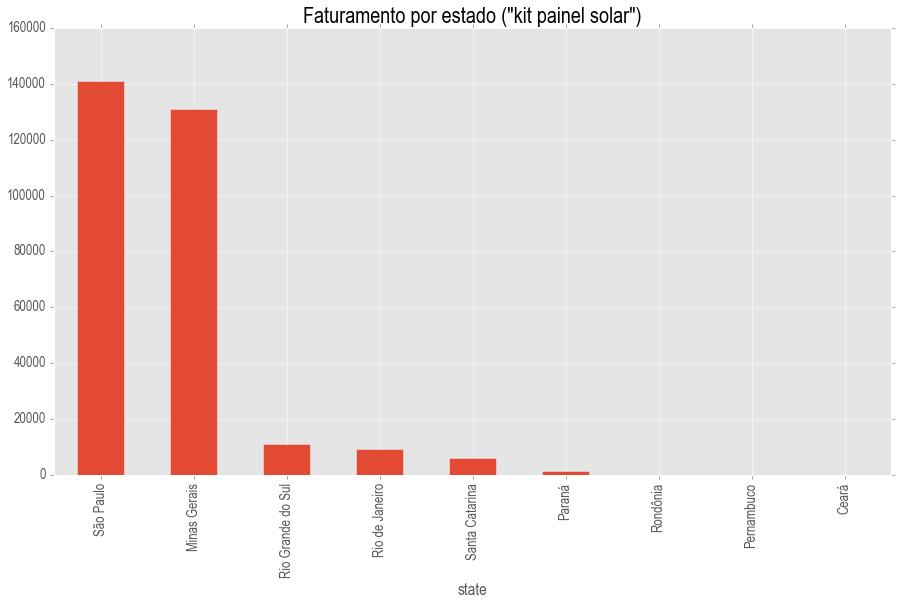

In [15]:
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))

revenue_by_state = df2.groupby('state').sum().revenue
revenue_by_state.sort_values(ascending=False).plot(kind='bar')
plt.title('Faturamento por estado ("' + query + '")', fontsize=22)

## Request por visitas dos itens filtrados e ordenados

- Get das visitas dos itens desde *DAYS_AGO* dias atrás 
- Organização dos resultados em um único **df** indexado por data
- Headers das colunas editados para serem as ids dos itens

In [16]:
#### REQUEST: get visits (by days) for the items in 'ids'

days = DAYS_AGO # number of days ago to consider
ids_string = ','.join(ids) # makes comma-separated string from list to use in URL

url = 'https://api.mercadolibre.com/items/visits/time_window?ids=' + ids_string +'&last=' + str(days) + '&unit=day'
data = requests.get(url).json()

visits_df = DataFrame(data[0]['results']) # initialize a df with the first item out of 10 (top ten in ids_string)
visits_df = visits_df[['date', 'total']] # gets only main columns
visits_df.columns = ['date', data[0]['item_id']] # renames 'total' to item's ID

column_headers = [] # list to store item ids used as column headers
column_headers.append(data[0]['item_id'])

# iterates over data items to merge all 'total' columns into same df
for item in data[1:]:
    results = item['results']
    df_temp = DataFrame(results)
    df_temp = df_temp[['date', 'total']]
    df_temp.columns = ['date', item['item_id']]
    column_headers.append(item['item_id'])
    visits_df = pd.merge(visits_df, df_temp, on='date')
    
#print(column_headers)
#visits_df.head()

In [17]:
# fixes df, parsing 'date' properly and setting as index column
visits_df['date'] = pd.to_datetime(visits_df['date'])
visits_df = visits_df.set_index('date')

visits_df.head()

,MLB712968328,MLB684532632,MLB695065272,MLB696113241,MLB754575430,MLB727650542,MLB779069064,MLB765601179,MLB773028235,MLB760460786
date,,,,,,,,,,
2015-10-20 04:00:00,0,24,144,67,0,0,0,0,0,0
2015-10-21 04:00:00,0,13,199,42,0,0,0,0,0,0
2015-10-22 04:00:00,0,7,175,55,0,0,0,0,0,0
2015-10-23 04:00:00,0,15,151,51,0,0,0,0,0,0
2015-10-24 04:00:00,0,11,133,54,0,0,0,0,0,0


## Visualização de visitas de 3 formas
- Visitas por dia (básico) (comentado)
- Média móvel de visitas (janela da média definida no código, ainda hardcoded)
- Soma acumulada de visitas (comentado)

In [18]:
#plt.figure()
#visits_df.plot(legend=True);
#plt.title('Histórico de visitas aos 10 itens mais vendidos ("' + query + '")', fontsize=22)

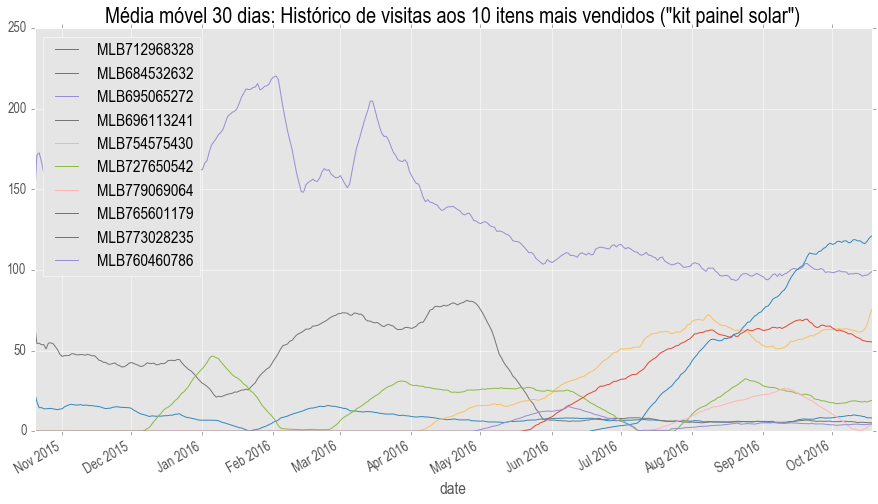

In [19]:
# calculates and plots visits' rolling mean (smoother curves)
#rolling_mean_df = visits_df.resample("1d").sum().fillna(0).rolling(window=30, min_periods=1).mean() #when resampling is needed

plt.figure();
days_rolling = 30;
rolling_mean_df = visits_df.rolling(window=days_rolling, min_periods=1).mean() # window is the # of days evaluated in rolling mean
rolling_mean_df.plot();
plt.title('Média móvel ' + str(days_rolling) + ' dias: Histórico de visitas aos 10 itens mais vendidos ("' + query + '")', fontsize=22)

In [20]:
#cumulative_visits_df = visits_df.cumsum() # calculates accumulated values to plot
#plt.figure();
#cumulative_visits_df.plot(legend=True);
#plt.title('Soma acumulada: Histórico de visitas aos 10 itens mais vendidos ("' + query + '")', fontsize=22)

## Todo:
- Plot itens by seller location
- Calculate revenue per seller (extract from seller dict in raw df)
- Fix query handling for 0 results
- Fix query handling for null query as input
- Fix documentation at the end
- Filter by minimum item price

## Todo (for version as a service):
- Compare sellers' itens with competitors: "how I am performing?"